In [1]:
import common, hdr, hsda, mesh_ppi, hacc
import pyart
import numpy as np

from importlib import reload

imports static in hsda
imports static in mesh

## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [9]:
reload(mesh_ppi)
reload(hacc)
reload(common)

imports static in mesh


<module 'common' from '/home/548/jss548/dev/repo-lib/pyhail/src/pyhail/common.py'>

In [18]:
#filename = "/home/jsoderho/Downloads/66_20231110_063000.pvol.h5"
filename = "/g/data/kl02/jss548/aura/testing_files/hail/66_20231110_063000.pvol.h5"
radar = pyart.aux_io.read_odim_h5(filename)

radar = hdr.pyart(radar,
                  'reflectivity_horizontal',
                  'differential_reflectivity')

radar = hsda.pyart(radar, 
          filename, 
          'reflectivity_horizontal', 
          'differential_reflectivity', 
          'cross_correlation_ratio', 
          'radar_classification',
          [4000, 5500], 
          [6, 7, 8])

"""
run retreivals that require the entire volume
"""
radar.add_field('ke', empty_radar_field)
radar.add_field('shi', empty_radar_field)
radar.add_field('mesh', empty_radar_field)
radar.add_field('posh', empty_radar_field)
radar.add_field('hacc', empty_radar_field)
#mesh
#build datasets
reflectivity_dataset = []
elevation_dataset = []
azimuth_dataset = []
range_dataset = []
elevation_dataset = []
radar_altitude = radar.altitude['data'][0]
for i, sweep_idx in enumerate(range(radar.nsweeps)):
    #filter out birdbath scans
    if radar.fixed_angle['data'][i] < 90:
        reflectivity_dataset.append(radar.get_field(sweep_idx, 'reflectivity_horizontal').data)
        azimuth_dataset.append(radar.get_azimuth(sweep_idx))
        range_dataset.append(radar.range['data'])
        elevation_dataset.append(radar.fixed_angle['data'][i])
#run retrieval
ke_dict, shi_dict, mesh_dict, posh_dict = mesh_ppi.main(reflectivity_dataset,
                                                    elevation_dataset,
                                                    azimuth_dataset,
                                                    range_dataset,
                                                    radar_altitude,
                                                    [4000,5500])

#hacc
sweep0_idx = np.argmin(elevation_dataset)
#run retrieval
sweep0_x, sweep0_y, sweep0_z = radar.get_gate_x_y_z(sweep0_idx)
print(sweep0_z)
hacc_dict = hacc.main(radar.get_field(sweep0_idx, 'reflectivity_horizontal').data, 
                        radar.get_field(sweep0_idx, 'hsda'),
                        mesh_dict['data'],
                        sweep0_z + radar_altitude,
                        4000, 700,
                        sp_reflectivity_threshold=55)


#update data
for i in range(len(elevation_dataset)):
    radar.fields['ke']['data'][radar.get_slice(i)] = ke_dict['data'][i]
radar.fields['shi']['data'][radar.get_slice(sweep0_idx)] = shi_dict['data']
radar.fields['mesh']['data'][radar.get_slice(sweep0_idx)] = mesh_dict['data']
radar.fields['posh']['data'][radar.get_slice(sweep0_idx)] = posh_dict['data']
radar.fields['hacc']['data'][radar.get_slice(sweep0_idx)] = hacc_dict['data']

#update metadata
radar = common.add_pyart_metadata(radar, 'ke', ke_dict)
radar = common.add_pyart_metadata(radar, 'shi', shi_dict)
radar = common.add_pyart_metadata(radar, 'mesh', mesh_dict)
radar = common.add_pyart_metadata(radar, 'posh', posh_dict)
radar = common.add_pyart_metadata(radar, 'hacc', hacc_dict)


[[1.62086201e+00 5.11140595e+00 8.60194867e+00 ... 1.33216991e+04
  1.33360298e+04 1.33503608e+04]
 [1.62086201e+00 5.11140595e+00 8.60194867e+00 ... 1.33216991e+04
  1.33360298e+04 1.33503608e+04]
 [1.62086201e+00 5.11140595e+00 8.60194867e+00 ... 1.33216991e+04
  1.33360298e+04 1.33503608e+04]
 ...
 [1.62086201e+00 5.11140595e+00 8.60194867e+00 ... 1.33216991e+04
  1.33360298e+04 1.33503608e+04]
 [1.62086201e+00 5.11140595e+00 8.60194867e+00 ... 1.33216991e+04
  1.33360298e+04 1.33503608e+04]
 [1.62086201e+00 5.11140595e+00 8.60194867e+00 ... 1.33216991e+04
  1.33360298e+04 1.33503608e+04]]


In [20]:
print(np.nanmax(radar.get_field(sweep0_idx, 'mesh')))

0.0


dict_keys(['reflectivity_horizontal', 'velocity_horizontal', 'total_power_horizontal', 'differential_reflectivity', 'cross_correlation_ratio', 'differential_phase', 'specific_differential_phase', 'hdr', 'hdr_size', 'hsda', 'radar_classification', 'ke', 'shi', 'mesh', 'posh', 'hacc'])


/scratch/kl02/jss548/tmp/ipykernel_3260304/4224431591.py:23: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = axs[0].pcolormesh(x_coords, y_coords, radar.get_field(sweep0_idx, 'reflectivity_horizontal'), cmap='jet')
/scratch/kl02/jss548/tmp/ipykernel_3260304/4224431591.py:26: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = axs[1].pcolormesh(x_coords, y_coords, radar.get_field(sweep0_idx, 'mesh'), cmap='hot_r')
/scratch/kl02/jss548/tmp/ipykernel_3260304/4224431591.py:29: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically 

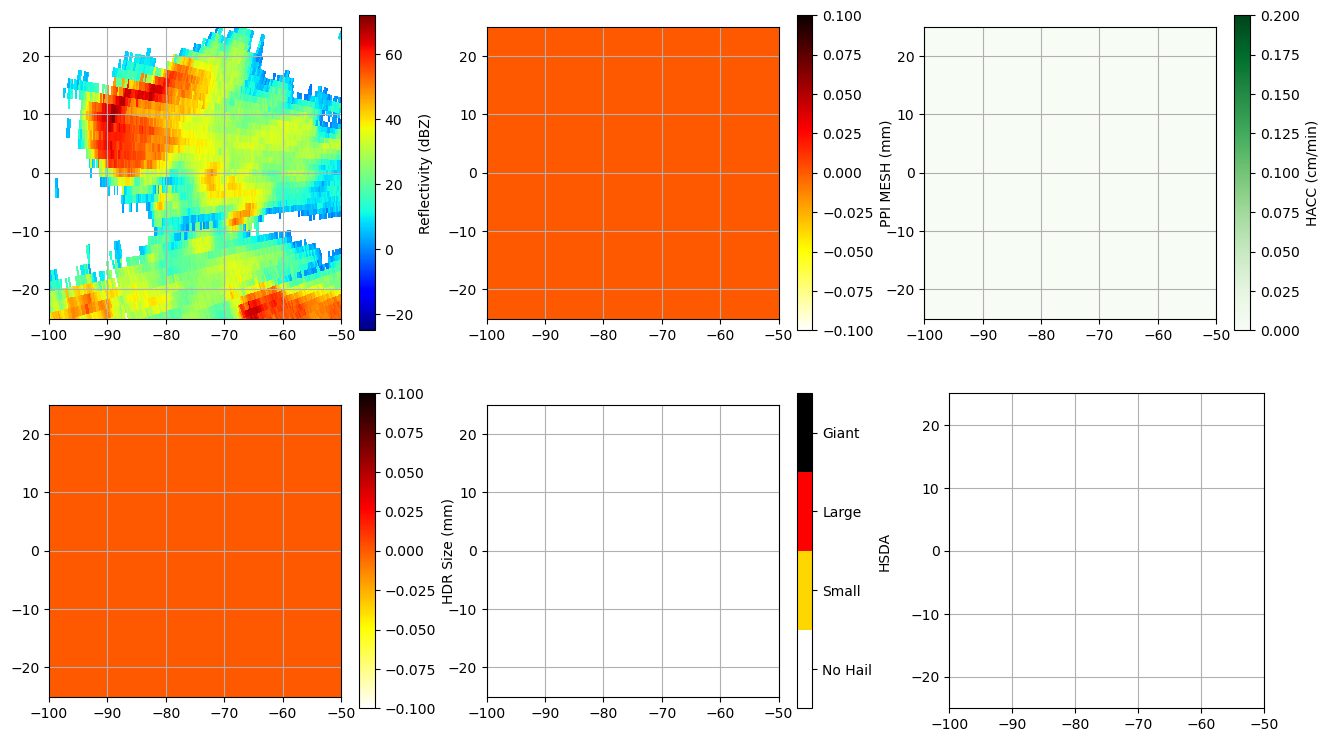

In [15]:
import cartopy.crs as ccrs
import matplotlib.pyplot as pl
import matplotlib.colors as colors
import numpy as np

x_coords = sweep0_x/1000
y_coords = sweep0_y/1000
x_lim = [-100,-50]
y_lim = [-25, 25]
hsda_colors = [
    "White",
    "Gold",
    "Red",
    "Black",
    ]
hsda_cmap = colors.ListedColormap(hsda_colors) 

print(radar.fields.keys())

fig, axs = pl.subplots(nrows=2, ncols=3, figsize=(16, 9))
axs = axs.flatten()

im = axs[0].pcolormesh(x_coords, y_coords, radar.get_field(sweep0_idx, 'reflectivity_horizontal'), cmap='jet')
cbar = fig.colorbar(im, ax=axs[0], label='Reflectivity (dBZ)')

im = axs[1].pcolormesh(x_coords, y_coords, radar.get_field(sweep0_idx, 'mesh'), cmap='hot_r')
cbar = fig.colorbar(im, ax=axs[1], label='PPI MESH (mm)')

im = axs[2].pcolormesh(x_coords, y_coords, radar.get_field(sweep0_idx, 'hacc'), cmap='Greens', vmax=0.2)
cbar = fig.colorbar(im, ax=axs[2], label='HACC (cm/min)')

im = axs[3].pcolormesh(x_coords, y_coords, radar.get_field(sweep0_idx, 'hdr_size'), cmap='hot_r')
cbar = fig.colorbar(im, ax=axs[3], label='HDR Size (mm)')

im = axs[4].pcolormesh(x_coords, y_coords, radar.get_field(sweep0_idx, 'hsda'), cmap=hsda_cmap, vmin=-0.5, vmax=3.5)
cbar = fig.colorbar(im, ax=axs[4], label='HSDA')
cbar.set_ticks([0, 1, 2, 3])
cbar.set_ticklabels(["No Hail", "Small", "Large", "Giant"])


for ax in axs:
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.grid()
    ax.set_aspect('equal', 'box')

